In [156]:
import json
from shapely.geometry import shape, Point
from shapely.ops import nearest_points
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request
import simplejson
from cluster_model import ClusterModel
from datetime import timedelta
import pickle
import seaborn as sns
import networkx as nx
from state_optimization import StateOptimization

# Boroughs

In [19]:
# use correct path to the geojson file
with open("/Users/Timothy/Documents/CSUREMM-main/new-york-city-boroughs.geojson") as f:
    boroughs_geojson = json.load(f)

# def classify_borough(lat, lon, boroughs_geojson):
#     point = Point(lon, lat)
#     for feature in boroughs_geojson['features']:
#         polygon = shape(feature['geometry'])
#         if polygon.contains(point):
#             return feature['properties']['name']  # or appropriate property name
#     return 'Unknown'

def classify_borough(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_borough = 'Unknown'
    
    for feature in boroughs_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
        # Calculate the distance to the nearest point on the polygon
        nearest_point = nearest_points(point, polygon)[1]
        distance = point.distance(nearest_point)
        if distance < min_distance:
            min_distance = distance
            nearest_borough = feature['properties']['name']
    
    return nearest_borough

In [23]:
# this may take a minute...
with open('/Users/Timothy/Documents/CSUREMM-main/data/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.006)
cluster_model.init_clusters()
# cluster_model.init_state(path='/Users/Timothy/Documents/CSUREMM-main/data/station_data/status_at_time/2024_6_20_2:19.csv',
#                          time=timedelta(hours=2))

boro_dict = {}
for cluster in cluster_model.cluster_dict.values():
    boro_dict[cluster.name] = classify_borough(cluster.lat, cluster.lon, boroughs_geojson)

30 horizontal squares and 43 vertical squares. Total squares: 1290


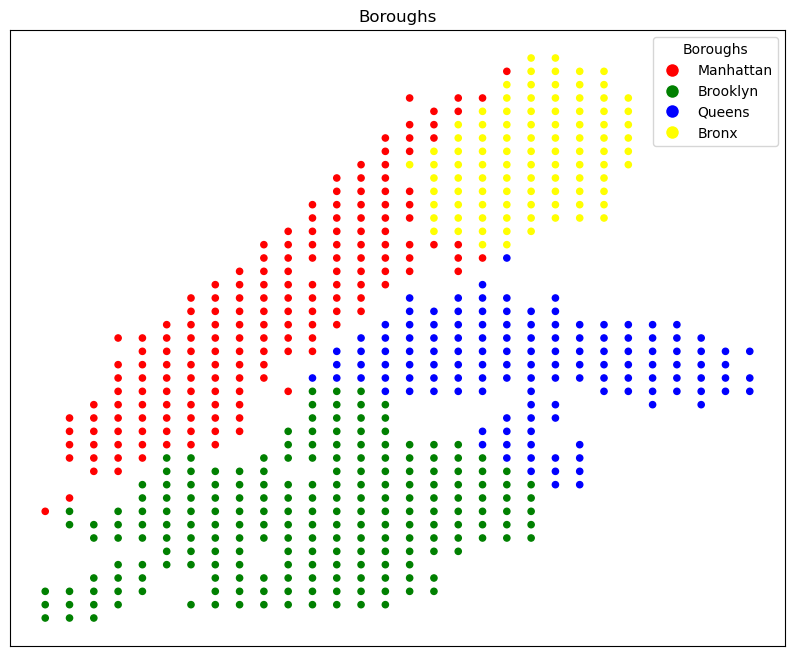

In [24]:
color_map = {'Manhattan': 'red', 'Brooklyn': 'green', 'Queens': 'blue', 'Bronx': 'yellow'}

G = nx.DiGraph()

positions = {}
node_colors = []

for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    borough = boro_dict.get(cluster.name, 'Unknown')
    node_colors.append(color_map.get(borough, 'lightgray'))  # Default to 'lightgray' if borough not found

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, positions, node_size=20, node_color=node_colors)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=borough, markersize=10, markerfacecolor=color) 
                   for borough, color in color_map.items()]
plt.legend(handles=legend_elements, title="Boroughs")
plt.title("Boroughs")
plt.show()

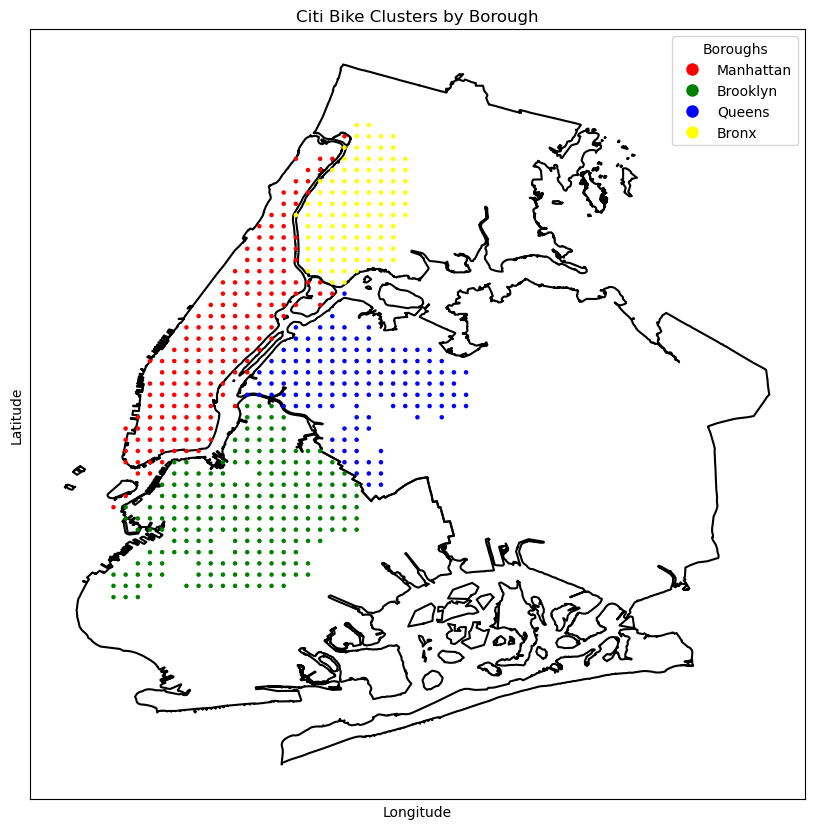

In [63]:
import json
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from geojson import load

# Load the GeoJSON file for borough boundaries
with open('/Users/Timothy/Documents/CSUREMM-main/new-york-city-boroughs.geojson') as f:
    geojson_data = load(f)

# Extract the geometries and borough names
geometries = []
borough_names = []

for feature in geojson_data['features']:
    geom = shape(feature['geometry'])
    borough_name = feature['properties']['name']
    
    if borough_name in color_map:  # Only add boroughs that have nodes
        geometries.append(geom)
        borough_names.append(borough_name)

# Plot the borough boundaries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, borough_name in zip(geometries, borough_names):
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y, 'k')

# For the nodes
color_map = {'Manhattan': 'red', 'Brooklyn': 'green', 'Queens': 'blue', 'Bronx': 'yellow'}

G = nx.DiGraph()

positions = {}
node_colors = []

# Assuming cluster_model and boro_dict are defined elsewhere
for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    borough = boro_dict.get(cluster.name, 'Unknown')
    if borough in color_map:  # Only add nodes for boroughs in color_map
        node_colors.append(color_map[borough])
    else:
        node_colors.append('lightgray')  # Default color for unknown boroughs

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, positions, node_size=5, node_color=node_colors, ax=ax)

# Create legend for boroughs
legend_elements = [Line2D([0], [0], marker='o', color='w', label=borough, markersize=10, markerfacecolor=color) 
                   for borough, color in color_map.items()]
ax.legend(handles=legend_elements, title="Boroughs")

# Add plot titles and labels
plt.title('Citi Bike Clusters by Borough')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


# Neighborhoods

In [30]:
with open("/Users/Timothy/Documents/CSUREMM-main/nyc-neighborhoods.geo.json") as f:
    neighborhoods_geojson = json.load(f)

In [31]:
def classify_neighborhood(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_borough = 'Unknown'
    
    for feature in neighborhoods_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
        # Calculate the distance to the nearest point on the polygon
        nearest_point = nearest_points(point, polygon)[1]
        distance = point.distance(nearest_point)
        if distance < min_distance:
            min_distance = distance
            nearest_neighborhood = feature['properties']['name']
    
    return nearest_neighborhood

In [33]:
# this may take a minute...
with open('/Users/Timothy/Documents/CSUREMM-main/data/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.006)
cluster_model.init_clusters()
# cluster_model.init_state(path='/Users/Timothy/Documents/CSUREMM-main/data/station_data/status_at_time/2024_6_20_2:19.csv',
#                          time=timedelta(hours=2))

neighborhood_dict = {}
for cluster in cluster_model.cluster_dict.values():
    neighborhood_dict[cluster.name] = classify_neighborhood(cluster.lat, cluster.lon, neighborhoods_geojson)

30 horizontal squares and 43 vertical squares. Total squares: 1290


In [105]:
# List of neighborhoods that actually have stations in them
neighborhood_list = []
for neighborhood in neighborhood_dict.values():
    if neighborhood not in neighborhood_list:
        neighborhood_list.append(neighborhood)

# List of bad neighborhoods to highlight in our graph
bad_neighborhoods = ['Flatbush', 'East Flatbush-Farragut', 'Sunset Park East', 'Sunset Park West', 'Crown Heights South', 'Crown Heights North']

In [98]:
neighborhood_list

['Spuyten Duyvil-Kingsbridge',
 'Van Cortlandt Village',
 'Marble Hill-Inwood',
 'Bedford Park-Fordham North',
 'Washington Heights North',
 'Kingsbridge Heights',
 'Belmont',
 'University Heights-Morris Heights',
 'Fordham South',
 'Mount Hope',
 'East Tremont',
 'Washington Heights South',
 'Claremont-Bathgate',
 'Highbridge',
 'East Concourse-Concourse Village',
 'West Concourse',
 'Morrisania-Melrose',
 'Crotona Park East',
 'Hamilton Heights',
 'Central Harlem North-Polo Grounds',
 'Melrose South-Mott Haven North',
 'Longwood',
 'Hunts Point',
 'Soundview-Bruckner',
 'Manhattanville',
 'East Harlem North',
 'Morningside Heights',
 'Central Harlem South',
 'Mott Haven-Port Morris',
 'Upper West Side',
 'East Harlem South',
 'Steinway',
 'Upper East Side-Carnegie Hill',
 'Yorkville',
 'Lincoln Square',
 'Old Astoria',
 'Clinton',
 'Midtown-Midtown South',
 'Lenox Hill-Roosevelt Island',
 'Queensbridge-Ravenswood-Long Island City',
 'Astoria',
 'Woodside',
 'Jackson Heights',
 'East 

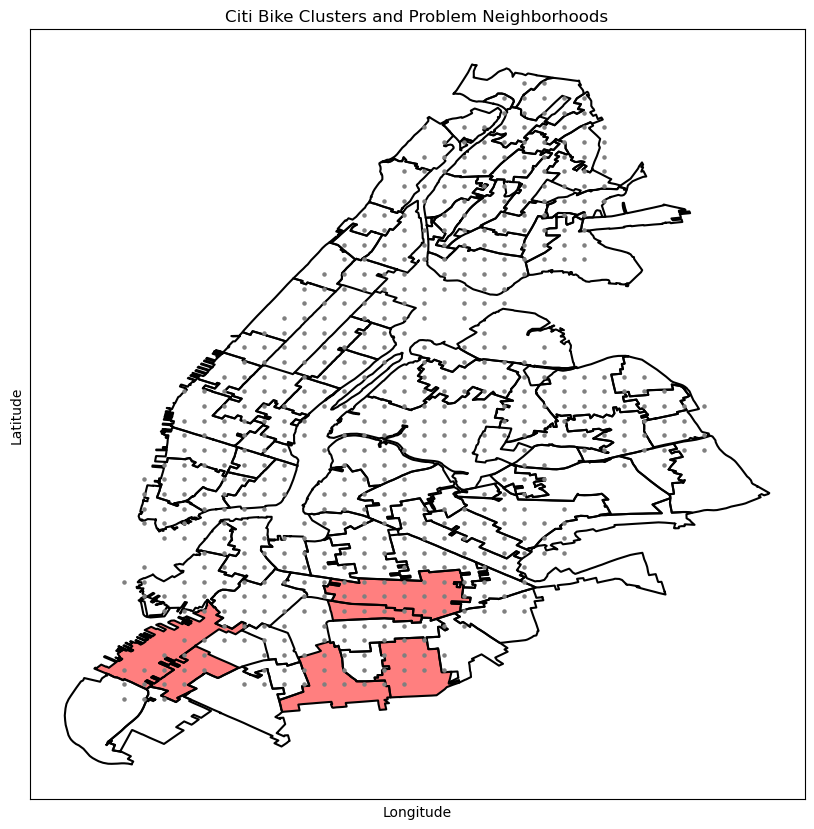

In [106]:
import json
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import networkx as nx
from geojson import load

# Load the GeoJSON file for neighborhood boundaries
with open("/Users/Timothy/Documents/CSUREMM-main/nyc-neighborhoods.geo.json") as f:
    geojson_data = load(f)

# Extract the geometries and properties (neighborhood names)
geometries = []
properties = []

for feature in geojson_data['features']:
    if feature['properties']['name'] in neighborhood_list:
        geometry = shape(feature['geometry'])
        properties.append(feature['properties'])
        geometries.append(geometry)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, prop in zip(geometries, properties):
    neighborhood_name = prop['name']
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        if neighborhood_name in bad_neighborhoods:
            ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            if neighborhood_name in bad_neighborhoods:
                ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
            ax.plot(x, y, 'k')

# Assuming cluster_model and neighborhood_dict are defined elsewhere
G = nx.DiGraph()
positions = {}

for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    neighborhood = neighborhood_dict.get(cluster.name, 'Unknown')

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, positions, node_size=5, node_color='gray', ax=ax)

# Add plot titles and labels
plt.title('Citi Bike Clusters and Problem Neighborhoods')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


### In case something goes wrong you can come back to this

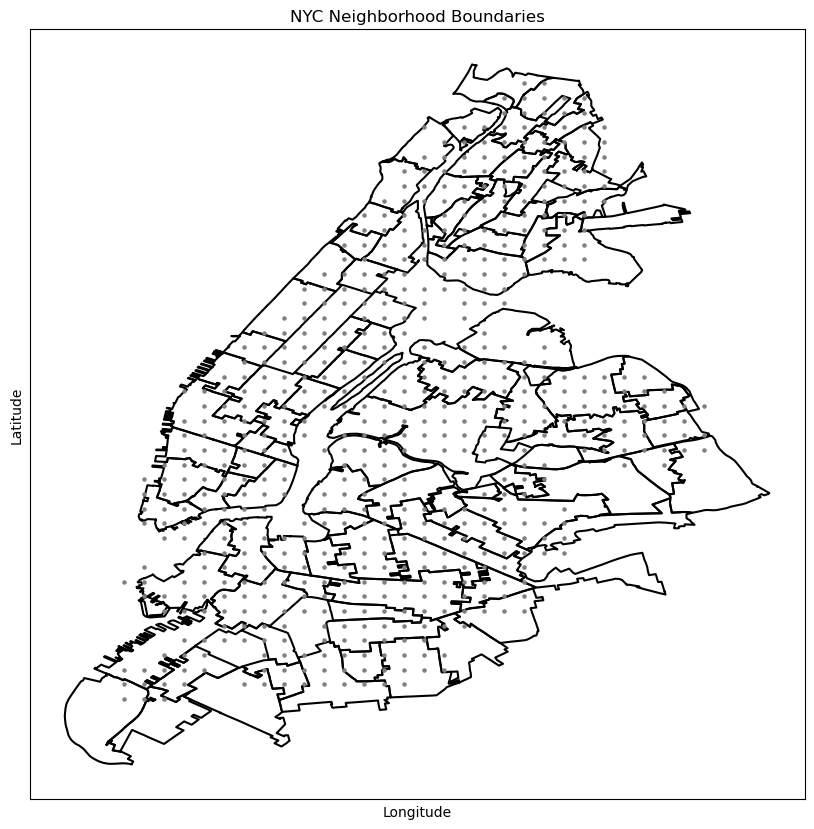

In [97]:
import json
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
from geojson import load

# Load the GeoJSON file
with open("/Users/Timothy/Documents/CSUREMM-main/nyc-neighborhoods.geo.json") as f:
    geojson_data = load(f)

# Extract the geometries
geometries = [shape(feature['geometry']) for feature in geojson_data['features'] 
              if feature['properties']['name'] in neighborhood_list]

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom in geometries:
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y, 'k')

G = nx.DiGraph()

positions = {}
node_colors = []

# Assuming cluster_model and neighborhood_dict are defined elsewhere
for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    neighborhood = neighborhood_dict.get(cluster.name, 'Unknown')

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, positions, node_size=5, node_color='gray', ax=ax)

# Add plot titles and labels
plt.title('NYC Neighborhood Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# IP w/ neighborhoods

Initialize the model and create borough and neighborhood dictionaries:

In [117]:
with open('/Users/Timothy/Documents/CSUREMM-main/data/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.006)
cluster_model.init_clusters()

30 horizontal squares and 43 vertical squares. Total squares: 1290


First, let's just focus on the bad neighborhoods in Brooklyn. There are some really low performing neighborhoods but also some that are pretty good. So, hopefully we can find truck routes within Brooklyn that work.

First, lets just visualize the bad stations in Brooklyn:

In [135]:
# List of neighborhoods that actually have stations in them
neighborhood_list, cluster_list = [], [] # cluster list is of objects, not names
for cluster in neighborhood_dict.keys():
    if boro_dict[cluster] == "Brooklyn":
        cluster_list.append(cluster_model.cluster_dict[cluster])
        if neighborhood_dict[cluster] not in neighborhood_list:
            neighborhood_list.append(neighborhood_dict[cluster])

# List of bad neighborhoods to highlight in our graph
bad_neighborhoods = ['Flatbush', 'East Flatbush-Farragut', 'Sunset Park East', 
                     'Sunset Park West', 'Crown Heights South', 'Crown Heights North']

len(cluster_list)

209

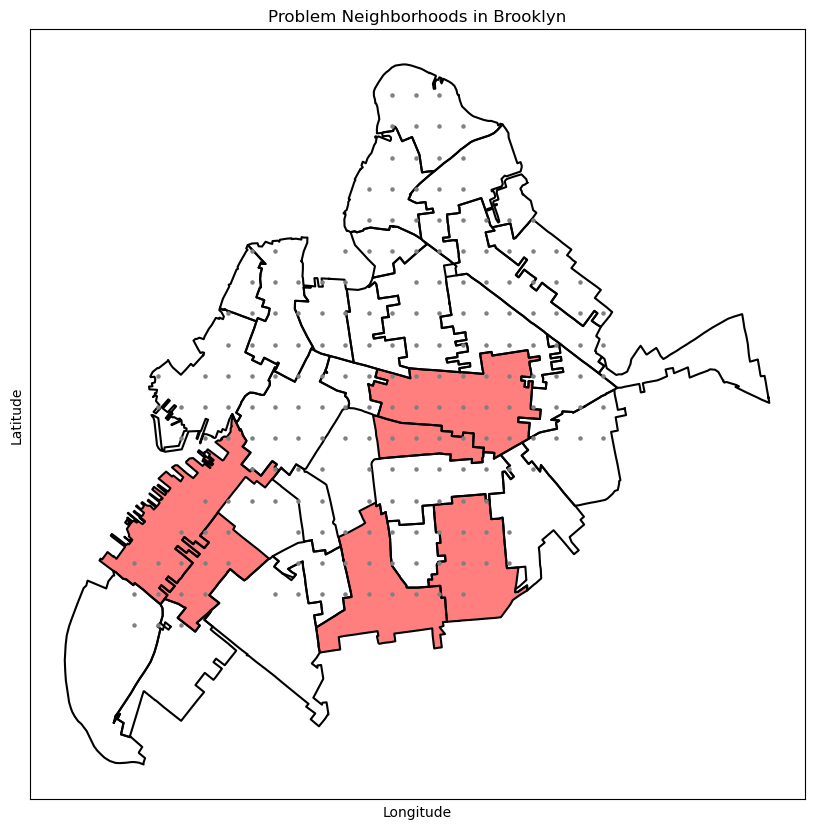

In [115]:
import json
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import networkx as nx
from geojson import load

# Load the GeoJSON file for neighborhood boundaries
with open("/Users/Timothy/Documents/CSUREMM-main/nyc-neighborhoods.geo.json") as f:
    geojson_data = load(f)

# Extract the geometries and properties (neighborhood names)
geometries = []
properties = []

for feature in geojson_data['features']:
    if feature['properties']['name'] in neighborhood_list:
        geometry = shape(feature['geometry'])
        properties.append(feature['properties'])
        geometries.append(geometry)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, prop in zip(geometries, properties):
    neighborhood_name = prop['name']
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        if neighborhood_name in bad_neighborhoods:
            ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            if neighborhood_name in bad_neighborhoods:
                ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
            ax.plot(x, y, 'k')

# Assuming cluster_model and neighborhood_dict are defined elsewhere
G = nx.DiGraph()
positions = {}

# for cluster in cluster_model.cluster_dict.values():
# This was modified bc we just wanted Brooklyn!
for cluster in cluster_list:
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    neighborhood = neighborhood_dict.get(cluster.name, 'Unknown')

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, positions, node_size=5, node_color='gray', ax=ax)

# Add plot titles and labels
plt.title('Problem Neighborhoods in Brooklyn')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

Now, we want to set up what we need for integer programming and then run it

In [154]:
T = 20
K = 1
L = 3

clusters = [cluster.name for cluster in cluster_list]
start_levels = {cluster.name: cluster.curr_bikes for cluster in cluster_model.cluster_dict.values() if cluster.name in cluster_list}
positions = {cluster.name: (cluster.lon, cluster.lat) for cluster in cluster_model.cluster_dict.values() if cluster.name in cluster_list}
adjacency = cluster_model.get_adjacent_clusters()
neighbors = adjacency.copy()
for cluster in adjacency.keys():
    if cluster not in clusters:
        del neighbors[cluster]

In [ ]:
# Still need to figure this one out a little
opt_state = state_optimization.optimize(length=timedelta(hours=4), steps=8)

In [ ]:
ip_model, x, y, b = ip.create_model(T=T, K=K, L=L, 
                start_levels=start_levels,
                stations=clusters, 
                optimal_levels=opt_state, 
                positions=positions,  
                neighbors=adjacency)

truck_paths = ip.graph_model(x, b, K, T, clusters, positions)